In [19]:
import pandas as pandas
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from sklearn.linear_model import LinearRegression, HuberRegressor
from torch.utils.data import DataLoader, Dataset
from typing import Tuple
from sklearn.preprocessing import StandardScaler


In [20]:
x_raw = np.arange(0,8,1)
y_raw = np.array([1,-1,2,-0.8,3,2,-0.25,4])

x_scaler = StandardScaler()
x = x_scaler.fit_transform(x_raw.reshape(-1,1))

y_scaler = StandardScaler()
y = y_scaler.fit_transform(y_raw.reshape(-1,1)).squeeze()


In [21]:
x

array([[-1.52752523],
       [-1.09108945],
       [-0.65465367],
       [-0.21821789],
       [ 0.21821789],
       [ 0.65465367],
       [ 1.09108945],
       [ 1.52752523]])

In [22]:
y

array([-0.14274419, -1.31397853,  0.44287299, -1.1968551 ,  1.02849016,
        0.44287299, -0.87476565,  1.61410733])

In [23]:
linreg = LinearRegression()
linreg.fit(x.reshape(-1,1),y)


LinearRegression()

In [24]:
huberreg = HuberRegressor()
huberreg.fit(x.reshape(-1,1), y)

HuberRegressor()

In [25]:
class CustomLoss(nn.Module):
    def __init__(
            self,
            threshold: float = 0.685,
            weight_max_error: float = 1,
            weight_percentage_above_threshold:float = 1,
            weight_wrong_sign: float = 1,
            sigmoid_steepness: float = 1,
    ) -> None:
        super().__init__()
        self.steepness = sigmoid_steepness
        self.threshold = threshold
        # Normalize weights and assign them
        sum_weights = (
            weight_max_error
            + weight_percentage_above_threshold
            + weight_wrong_sign
        )
        self.weight_max_error = (
            weight_max_error / sum_weights
        )
        self.weight_percentage_above_threshold = (
            weight_percentage_above_threshold / sum_weights
        )
        self.weight_wrong_sign = (
            weight_wrong_sign / sum_weights
        )

    def forward(
            self, 
            inputs: torch.Tensor, 
            targets: torch.Tensor,
        ) -> torch.Tensor:

        residuals = targets - inputs
        # Maximum abs error
        max_error = residuals.abs().max()

        # Percentage of time above threshold value
        percentage_of_time_above_x = (
            1/(1+torch.e**(-self.steepness*(residuals.abs()-self.threshold)))
        ).mean()

        # Percentage of time wrong sign
        loss_percentage_of_time_wrong_sign = (
            1/(1+torch.e**(-self.steepness*(inputs*targets)))
        ).mean()
        
        # Total loss
        total_loss = (
            self.weight_max_error * max_error
            + self.weight_percentage_above_threshold * percentage_of_time_above_x
            + self.weight_wrong_sign * loss_percentage_of_time_wrong_sign
        )
        return total_loss

In [26]:
class Model(nn.Module):
    def __init__(
            self,
            n_features: int,
    ) -> None:
        super().__init__()
        self.fc1 = nn.Linear(
            in_features=n_features,
            out_features=1,
        )  # Just 1 fully connected layer without activation, i.e. a linear regression.

    def forward(
        self,  
        X: torch.Tensor,  
    ) -> torch.Tensor:
        y = self.fc1(X)
        return y.flatten()

In [27]:
class CustomDataset(Dataset):
    def __init__(
            self,
            X: torch.Tensor,
            y: torch.Tensor,
        ) -> None:
        self.X = X
        self.y = y

    def __len__(
            self
    ) -> int:
        return self.X.shape[0]
    
    def __getitem__(
            self,
            idx: int,
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        X_item = self.X[idx,:]
        y_item = self.y[idx]
        return X_item, y_item

In [28]:
class CustomMSELoss(nn.Module):
    def __init__(
            self,
    ) -> None:
        super().__init__()


    def forward(
            self, 
            inputs: torch.Tensor, 
            targets: torch.Tensor,
        ) -> torch.Tensor:

        residuals = targets - inputs
        mse = (residuals**2).mean()
        return mse

In [29]:
class CustomMAELoss(nn.Module):
    def __init__(
            self,
    ) -> None:
        super().__init__()


    def forward(
            self, 
            inputs: torch.Tensor, 
            targets: torch.Tensor,
        ) -> torch.Tensor:

        residuals = targets - inputs
        mae = residuals.abs.mean()
        return mae

In [30]:
epochs = 10000
lr = 1e-4
batch_size = 9

dataloader = DataLoader(
    CustomDataset(
        torch.Tensor(x).float(),
        torch.Tensor(y).float(),
    ),
    batch_size=batch_size,
    shuffle=True,
)
model_rmse = Model(
    n_features=1,
)
optimizer = torch.optim.Adam(
    model_rmse.parameters(),
    lr = lr,
)
criterion = CustomMSELoss()
for epoch in range(epochs):
    epoch_loss = 0
    for i,(X_batch, y_batch) in enumerate(dataloader):
        prediction = model_rmse(X_batch).flatten()
        optimizer.zero_grad()
        loss = criterion(prediction, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        average_loss = epoch_loss/(i+1)
    print(f"Average epoch loss: {average_loss}")
    print(f"Epoch {epoch} done.")

Average epoch loss: 0.855079174041748
Epoch 0 done.
Average epoch loss: 0.8550098538398743
Epoch 1 done.
Average epoch loss: 0.8549405336380005
Epoch 2 done.
Average epoch loss: 0.8548712730407715
Epoch 3 done.
Average epoch loss: 0.8548020124435425
Epoch 4 done.
Average epoch loss: 0.854732871055603
Epoch 5 done.
Average epoch loss: 0.8546637296676636
Epoch 6 done.
Average epoch loss: 0.8545946478843689
Epoch 7 done.
Average epoch loss: 0.854525625705719
Epoch 8 done.
Average epoch loss: 0.8544566035270691
Epoch 9 done.
Average epoch loss: 0.8543877005577087
Epoch 10 done.
Average epoch loss: 0.8543188571929932
Epoch 11 done.
Average epoch loss: 0.8542500138282776
Epoch 12 done.
Average epoch loss: 0.854181170463562
Epoch 13 done.
Average epoch loss: 0.8541123867034912
Epoch 14 done.
Average epoch loss: 0.8540437817573547
Epoch 15 done.
Average epoch loss: 0.8539750576019287
Epoch 16 done.
Average epoch loss: 0.8539064526557922
Epoch 17 done.
Average epoch loss: 0.8538379073143005
Epo

Average epoch loss: 0.8428874611854553
Epoch 190 done.
Average epoch loss: 0.842828631401062
Epoch 191 done.
Average epoch loss: 0.8427698016166687
Epoch 192 done.
Average epoch loss: 0.8427110314369202
Epoch 193 done.
Average epoch loss: 0.8426523804664612
Epoch 194 done.
Average epoch loss: 0.8425937294960022
Epoch 195 done.
Average epoch loss: 0.8425352573394775
Epoch 196 done.
Average epoch loss: 0.8424766063690186
Epoch 197 done.
Average epoch loss: 0.8424181342124939
Epoch 198 done.
Average epoch loss: 0.842359721660614
Epoch 199 done.
Average epoch loss: 0.8423013687133789
Epoch 200 done.
Average epoch loss: 0.8422430753707886
Epoch 201 done.
Average epoch loss: 0.8421847820281982
Epoch 202 done.
Average epoch loss: 0.8421266078948975
Epoch 203 done.
Average epoch loss: 0.8420684337615967
Epoch 204 done.
Average epoch loss: 0.8420103192329407
Epoch 205 done.
Average epoch loss: 0.8419522643089294
Epoch 206 done.
Average epoch loss: 0.8418942093849182
Epoch 207 done.
Average epoc

In [31]:
model_rmse.fc1.weight

Parameter containing:
tensor([[0.4561]], requires_grad=True)

In [32]:
model_rmse.fc1.bias

Parameter containing:
tensor([3.1831e-08], requires_grad=True)

In [33]:
linreg.coef_

array([0.45605821])

In [34]:
linreg.intercept_

0.0

In [35]:
# line1 = np.ones_like(y)*3
# line2 = 0.25*x
# line3 = 4*x

# ax.plot(x,line1, color = "red")
# ax.scatter(x,line1, color = "red")

# ax.plot(x, line2, color = "black")
# ax.scatter(x, line2, color = "black")

# ax.plot(x, line3, color = "green")
# ax.scatter(x, line3, color = "green")


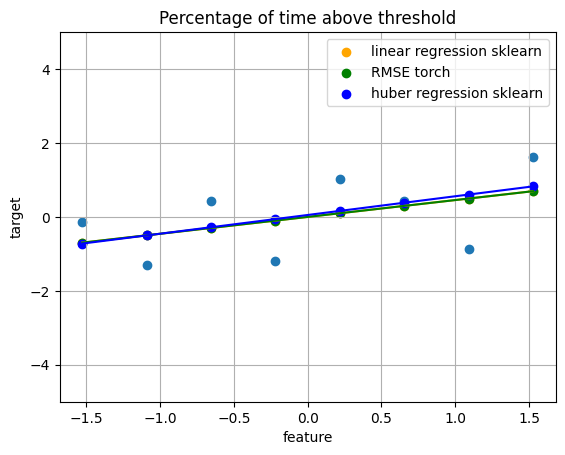

In [41]:
torch_prediction = model_rmse(torch.Tensor(x).float()).detach().numpy()

fig, ax = plt.subplots()
ax.scatter(x,y)

ax.scatter(x, linreg.predict(x.reshape(-1,1)), label = "linear regression sklearn", color = "orange")
ax.plot(x, linreg.predict(x.reshape(-1,1)), color = "orange")

ax.scatter(x, torch_prediction, label = "RMSE torch", color = "green")
ax.plot(x, torch_prediction, color = "green")

ax.scatter(x, huberreg.predict(x.reshape(-1,1)), label = "huber regression sklearn", color = "blue")
ax.plot(x, huberreg.predict(x.reshape(-1,1)), color = "blue")



ax.set_xlabel("feature")
ax.set_ylabel("target")
ax.set_title("Percentage of time above threshold")
ax.set_ylim(-5,5)
ax.grid()
ax.legend()

In [37]:
model(torch.Tensor(x).float()).detach().numpy()

NameError: name 'model' is not defined